In [2]:
######################## 对txt结果文件去重 ##########################
# 指定输入和输出文件名
input_file = '../results/adult/fairhsic_bin/0.05/msp_exp_bin_res.txt'
output_file = '../results/adult/fairhsic_bin/0.05/msp_exp_bin_res.txt'

# 使用集合来存储唯一的行
seen_lines = set()
unique_lines = []

with open(input_file, 'r', encoding='utf-8') as infile:
    for line in infile:
        # 去除行尾的换行符
        stripped_line = line.strip()
        if stripped_line not in seen_lines:
            seen_lines.add(stripped_line)
            unique_lines.append(stripped_line)

# 将行按第六列至第八列升序排序
unique_lines.sort(key=lambda x: (x.split()[5], x.split()[6], x.split()[7]))

with open(output_file, 'w', encoding='utf-8') as outfile:
    for line in unique_lines:
        outfile.write(line + '\n')



In [64]:
#################### 4轮run的平均结果 #######################
import pandas as pd

# 读取TXT文件，假设列是以空格或制表符分隔
input_file = '../results/adult/mfd_bin/0.1/energy_exp_mfd_bin_res.txt'
output_file = '../results/adult/mfd_bin/0.1/energy_exp_mfd_bin_res_avg.txt'

df = pd.read_csv(input_file, delimiter='\s+', header=None)

if df.shape[1] != 9:
    raise ValueError(f"Expected 9 columns, but got {df.shape[1]}")

# 按第6, 7, 8列分组
# 按第7, 8, 9列分组
grouped = df.groupby([df.columns[5], df.columns[6], df.columns[7]])

# 打印每个组的大小
# for name, group in grouped:
#     print(f"组名: {name}, 行数: {len(group)}")
#     print(group)
#     print("\n")

# 对每组分成每4行一个子组，并计算平均值
def compute_group_avg(group):
    # 计算子组的数量，忽略不足4行的子组
    num_subgroups = len(group) // 4
    
    if num_subgroups == 0:
        return pd.DataFrame()
    
    result = []
    for i in range(num_subgroups):
        subgroup = group.iloc[i*4:(i+1)*4]
        # print(f"子组 {i+1}/{num_subgroups}:")
        # print(subgroup)
        result.append(subgroup.mean())
    
    return pd.DataFrame(result)

avg_df = grouped.apply(compute_group_avg).reset_index(drop=True)

# 按第二列升序排列
sorted_avg_df = avg_df.sort_values(by=avg_df.columns[0])

# 打印排序后并去重前的数据
# print("排序后并去重前的数据:")
# print(sorted_avg_df)

# 去重，确保没有重复的行
sorted_avg_df = sorted_avg_df.drop_duplicates()

# 重新对 sorted_avg_df 进行分组以计算组的数量
new_grouped = sorted_avg_df.groupby([sorted_avg_df.columns[5], sorted_avg_df.columns[6], sorted_avg_df.columns[7]])
number_of_new_groups = new_grouped.ngroups

print("sorted_avg_df 中的组数量：", number_of_new_groups)

# 查看 sorted_avg_df 的前几行以确认内容
# print(sorted_avg_df.head())

# 保存到新的avg文件
sorted_avg_df.to_csv(output_file, sep='\t', index=False, header=False, float_format='%.2f')
print("新文件已生成：", output_file)


sorted_avg_df 中的组数量： 3
新文件已生成： ../results/adult/mfd_bin/0.1/energy_exp_mfd_bin_res_avg.txt


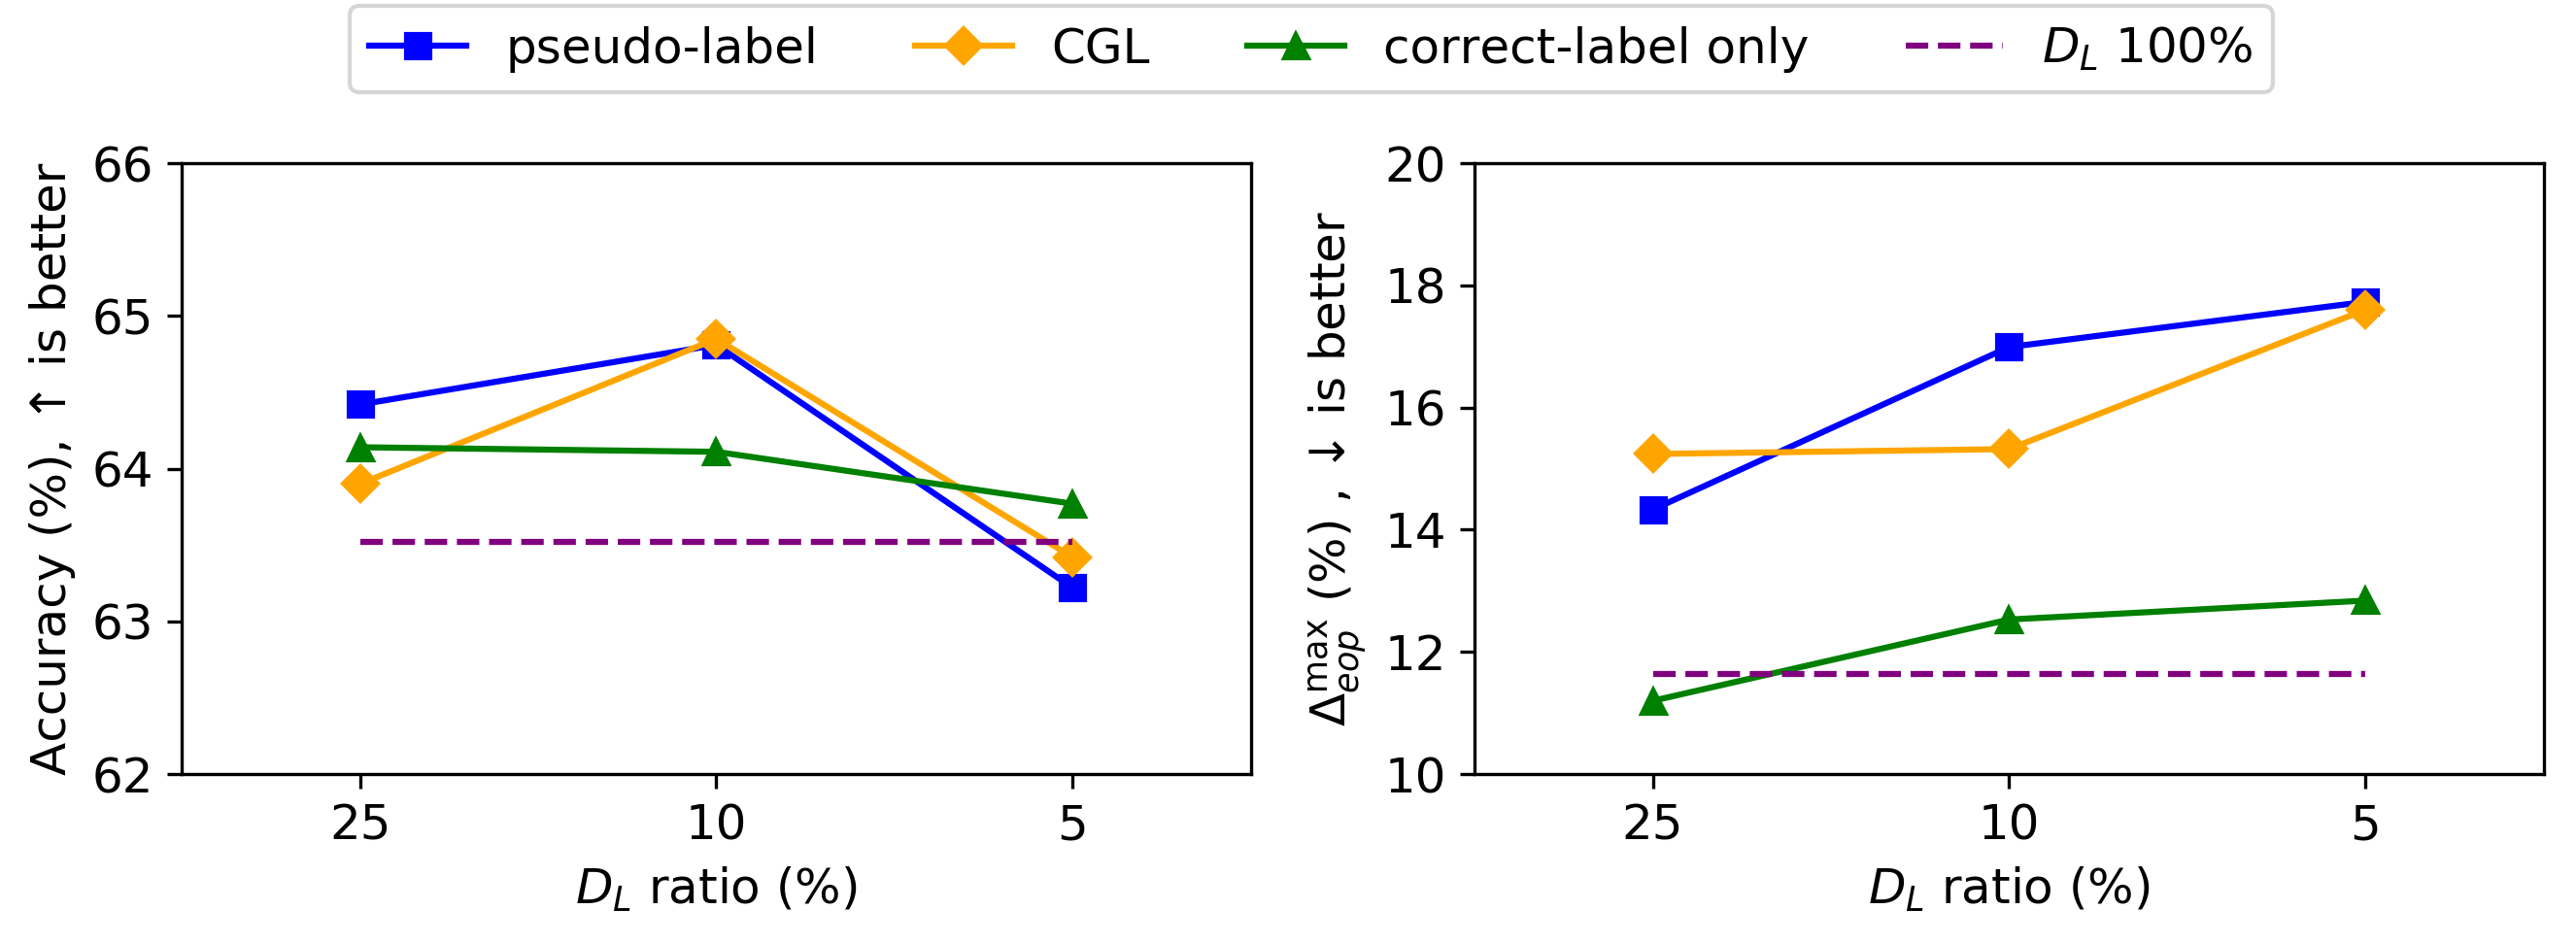

In [2]:
############### 真正的画CGL图 #########################
import matplotlib.pyplot as plt
import numpy as np

# 设置全局字体大小
plt.rcParams.update({'font.size': 12})

# 准备数据
group_label_ratio = np.array([25, 10, 5])
uniform_group_label_ratio = np.arange(1, 4)  # 用于保持间隔相等的x轴

# 反转数据顺序
accuracy_pseudo = np.array([64.42, 64.81, 63.22])
accuracy_CGL = np.array([63.90, 64.85, 63.42])
accuracy_remove_miss = np.array([64.14, 64.11, 63.77])
accuracy_fully_annotated = np.array([63.52, 63.52, 63.52])

fairness_pseudo = np.array([14.33, 16.99, 17.73])
fairness_CGL = np.array([15.24, 15.32, 17.60])
fairness_remove_miss = np.array([11.20, 12.53, 12.84])
fairness_fully_annotated = np.array([11.64, 11.64, 11.64])

# 创建图形，增加 DPI 参数
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3), dpi=300)  # 调整figsize参数使图形更小

# 准确率子图
ax1.plot(uniform_group_label_ratio, accuracy_pseudo, 's-', color='blue', label='pseudo-label')
ax1.plot(uniform_group_label_ratio, accuracy_CGL, 'D-', color='orange', label='CGL')
ax1.plot(uniform_group_label_ratio, accuracy_remove_miss, '^-', color='green', label='correct-label only')
ax1.plot(uniform_group_label_ratio, accuracy_fully_annotated, 'm--', color='purple', label=r'$D_L$ 100%')
ax1.set_xlabel(r'$D_L$ ratio (%)')
ax1.set_ylabel('Accuracy (%), ↑ is better')
ax1.set_ylim(62, 66)  # 留出上下空白
ax1.set_xlim(0.5, 3.5)  # 留出左右空白
ax1.set_xticks(uniform_group_label_ratio)
ax1.set_xticklabels(['25', '10', '5'])
ax1.set_yticks(np.arange(62, 67, 1))

# 公平性子图
ax2.plot(uniform_group_label_ratio, fairness_pseudo, 's-', color='blue', label='pseudo-label')
ax2.plot(uniform_group_label_ratio, fairness_CGL, 'D-', color='orange', label='CGL')
ax2.plot(uniform_group_label_ratio, fairness_remove_miss, '^-', color='green', label='correct-label only')
ax2.plot(uniform_group_label_ratio, fairness_fully_annotated, 'm--', color='purple', label=r'$D_L$ 100%')
ax2.set_xlabel(r'$D_L$ ratio (%)')
ax2.set_ylabel(r'$\Delta_{eop}^{\mathrm{max}}$ (%) , ↓ is better')
ax2.set_ylim(10, 20)  # 留出上下空白
ax2.set_xlim(0.5, 3.5)  # 留出左右空白
ax2.set_xticks(uniform_group_label_ratio)
ax2.set_xticklabels(['25', '10', '5'])
ax2.set_yticks(np.arange(10, 21, 2))

# 全局图例
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.1))  # 增加ncol参数并调整bbox_to_anchor

plt.tight_layout()

# 保存为高分辨率的pdf格式
plt.savefig('fig1.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

plt.show()


In [1]:
####################### 打对打错柱状图 ########################
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
from matplotlib.backends.backend_pdf import PdfPages

# 函数：读取并处理文件数据
def process_data(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
    data_green = np.array([float(x) for x in lines[0].split()])
    data_blue = np.array([float(x) for x in lines[1].split()])
    # 为数据点添加标签
    labeled_data_green = [(x, 'green') for x in data_green]
    labeled_data_blue = [(x, 'blue') for x in data_blue]
    # 合并数据
    all_labeled_data = np.array(labeled_data_green + labeled_data_blue, dtype=[('value', 'f4'), ('color', 'U5')])
    # 根据数据点的值进行排序
    all_labeled_data.sort(order='value')

    return all_labeled_data

# 函数：计算区间green、blue数量
def calculate_interval_counts(data, num_intervals=5):
    intervals = np.array_split(data, num_intervals)
    # 初始化统计结果
    count_green = []
    count_blue = []
    for interval in intervals:
        # 对于每个区间，统计颜色为'green'的元素数量
        green_count = np.sum(interval['color'] == 'green')
        count_green.append(green_count)
        # 同样，统计颜色为'blue'的元素数量
        blue_count = np.sum(interval['color'] == 'blue')
        count_blue.append(blue_count)
    return count_green, count_blue

# 函数：绘制柱状图
def draw_histogram(count_green_mean, count_blue_mean, title, ax):
    # 绘制柱状图
    x = np.arange(len(count_green_mean))  # 柱状图的x坐标
    width = 0.35  # 柱状图的宽度
    rects1 = ax.bar(x - width/2, count_green_mean, width, label='Hit', color='green')
    rects2 = ax.bar(x + width/2, count_blue_mean, width, label='Miss', color='blue')
    # 添加一些文本标签
    ax.set_xlabel('MSP value intervals', fontsize=12)
    ax.set_ylabel('Counts', fontsize=12)
    ax.set_title(title, fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels([f"{i+1}-{i+2}" for i in range(len(count_green_mean))])
    ax.legend()

    for rect1, rect2 in zip(rects1, rects2):
        height1 = rect1.get_height()
        height2 = rect2.get_height()
        total_height = height1 + height2
        percent1 = height1 / total_height if total_height != 0 else 0
        percent2 = height2 / total_height if total_height != 0 else 0
        ax.annotate(f'{percent1:.2%}',
                    xy=(rect1.get_x() + rect1.get_width() / 2, height1),
                    xytext=(0, 1),  # 1 points vertical offset
                    textcoords="offset points",
                    fontsize=12,
                    ha='center', va='bottom')
        ax.annotate(f'{percent2:.2%}',
                    xy=(rect2.get_x() + rect2.get_width() / 2, height2),
                    xytext=(0, 1),  # 1 points vertical offset
                    textcoords="offset points",
                    fontsize=12,
                    ha='center', va='bottom')
        
    # 计算并显示绿色柱子总量占比
    total_green = np.sum(count_green_mean)
    total_blue = np.sum(count_blue_mean)
    total = total_green + total_blue
    percent_green = total_green / total * 100 if total != 0 else 0

    # 在各自子图的中间添加占比信息，确保文字不会重叠
    mid_x_position = (x[-1] + width) / 2  # 计算x轴的中点位置
    mid_y_position = ax.get_ylim()[1] - (ax.get_ylim()[1] * 0.1)  # 从顶部留出一些空间
    # ax.text(mid_x_position, mid_y_position, f'Hit Ratio: {percent_green:.2f}%', color='red', fontweight='bold', fontsize=15, ha='center')

# 主程序：遍历目录并生成PDF
datasets = ['adult','compas']  
ratios = ['0.25', '0.1', '0.05']
project_path = os.getcwd()
current_date = datetime.date.today()
pdf_filename = os.path.join(project_path, "../distances/fig2.pdf")

with PdfPages(pdf_filename) as pdf:
    fig, axes = plt.subplots(len(datasets), len(ratios), figsize=(16, 10))
    axes = axes.flatten()  # 将axes数组展平成一维
    for i, dataset in enumerate(datasets):
        for j, ratio in enumerate(ratios):
            directory = f"../distances/{dataset}/{ratio}"
            all_interval_counts_green = []
            all_interval_counts_blue = []
            for k in range(1, 5):
                filename = os.path.join(directory, str(k), 'hit_miss_msp.txt')
                if os.path.exists(filename):
                    all_data = process_data(filename)
                    interval_counts_green, interval_counts_blue = calculate_interval_counts(all_data)
                    all_interval_counts_green.append(interval_counts_green)
                    all_interval_counts_blue.append(interval_counts_blue)

            # 计算4个文件的区间数量的平均值
            final_means_green = np.mean(all_interval_counts_green, axis=0)
            final_means_blue = np.mean(all_interval_counts_blue, axis=0)

            # 绘制柱状图
            title = f"{dataset} - {ratio}"
            draw_histogram(final_means_green, final_means_blue, title, axes[i * len(ratios) + j])
            axes[i * len(ratios) + j].set_ylim(0, axes[i * len(ratios) + j].get_ylim()[1])  # 将y轴高度缩小25%

    plt.tight_layout()
    pdf.savefig(fig)  # 保存当前的fig到PDF
    plt.close(fig)  # 关闭图形以释放资源


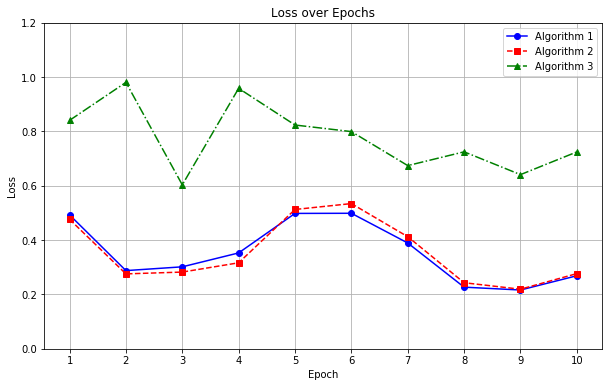

In [2]:
###################### 解释实验结果 ##########################
import matplotlib.pyplot as plt
import numpy as np

# 生成随机的loss数据
epochs = np.arange(1, 11)
# 两组接近的loss数据
loss_values1 = np.random.uniform(low=0.2, high=0.5, size=10)
loss_values2 = loss_values1 + np.random.uniform(low=-0.05, high=0.05, size=10)
# 一组不同的loss数据
loss_values3 = np.random.uniform(low=0.6, high=1.0, size=10)

# 创建折线图
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values1, marker='o', linestyle='-', color='b', label='Algorithm 1')
plt.plot(epochs, loss_values2, marker='s', linestyle='--', color='r', label='Algorithm 2')
plt.plot(epochs, loss_values3, marker='^', linestyle='-.', color='g', label='Algorithm 3')

plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.xticks(epochs)
plt.ylim(0, 1.2)  # 设置y轴范围以更好地展示数据
plt.legend()

# 显示图表
plt.show()


In [2]:
##################### 填实验结果表 ###################
import pandas as pd

# 假设文件路径
file_path = '../results/compas/fairhsic_cgl/0.25/pseudo_res.txt'

# 读取数据
data = pd.read_csv(file_path, header=None, delim_whitespace=True)

# 计算每列的平均值和标准差
means = data.mean()
std_devs = data.std()

# 格式化结果
result = means.map('{:.2f}'.format) + ' ± ' + std_devs.map('{:.2f}'.format)

# 将结果保存回文件
result_file_path = file_path
# result_file_path = '../results/adult/mfd_cgl/0.1/pseudo_res_final.txt'
result.to_csv(result_file_path, index=False, header=False)

print(f'结果已保存到 {result_file_path}')


结果已保存到 ../results/compas/fairhsic_cgl/0.25/pseudo_res.txt
